# When Phone Rings - Review Analysis

![Cover photo](cover-img.jpg){: style="float: left"}
Analysis of reviews from dorama When Phone Rings. Revies were taken from the [DoramaLive](https://10.doramalive.news/dorama/nabrannyy_vami_nomer_2024/#reviews)



In [1]:
import os
from bs4 import BeautifulSoup

In [2]:

# Define the Review class
class Review:
    def __init__(self, id, user_level, user_category, date, text, recommend, thumbs_up, thumbs_down, stars):
        self.id = id
        self.user_level = user_level
        self.user_category = user_category
        self.date = date
        self.text = text
        self.recommend = recommend
        self.thumbs_up = thumbs_up
        self.thumbs_down = thumbs_down
        self.stars = stars

    def __repr__(self):
        return (f"Review(id={self.id}, user_level={self.user_level}, user_category={self.user_category}, "
                f"date={self.date}, text={self.text}, recommend={self.recommend}, "
                f"thumbs_up={self.thumbs_up}, thumbs_down={self.thumbs_down}, stars={self.stars})")


In [3]:
# Function to scrape reviews
def scrape_reviews(folder_path, container_id):
    all_reviews = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.endswith('.html') and os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                soup = BeautifulSoup(file, 'html.parser')
                container = soup.find('div', id=container_id)
                if container:
                    for item in container.find_all('div', class_='item'):
                        id = item['id']
                        user_level = item.find('div', class_='lavel').text.strip()
                        user_category = item.find('div', class_='status').text.strip()
                        date = item.find('span', class_='date').text.strip()
                        text = item.find('div', class_='detail-more').p.text.strip()
                        recommend = bool(item.find('span', class_='label') and 'Рекомендую' in item.find('span', class_='label').text.strip())
                        thumbs_up = item.find('button', {'data-type': 'like'}).find('span')
                        thumbs_up = int(thumbs_up.text.strip()) if thumbs_up and thumbs_up.text.strip().isdigit() else 0
                        thumbs_down = item.find('button', {'data-type': 'dislike'}).find('span')
                        thumbs_down = int(thumbs_down.text.strip()) if thumbs_down and thumbs_down.text.strip().isdigit() else 0
                        stars = float(item.find('div', class_='vote-detail').text.split()[-1].replace(',', '.'))
                        all_reviews.append(Review(id, user_level, user_category, date, text, recommend, thumbs_up, thumbs_down, stars))
    return all_reviews

In [4]:
# Root folder path and container ID
templates_folder = 'templates'  # Update this path if necessary
container_id = "comp_473e83c528a6b0348156131b4817f803"  # Update the container ID as needed

# Scrape and print all reviews
raw_reviews = scrape_reviews(templates_folder, container_id)


In [5]:
print(len(raw_reviews))

63


### Parse Date Time

In [6]:
from datetime import datetime

# Map Russian month abbreviations to their numeric equivalents
month_map = {
    'янв': '01', 'фев': '02', 'мар': '03', 'апр': '04', 'май': '05', 'июн': '06',
    'июл': '07', 'авг': '08', 'сен': '09', 'окт': '10', 'ноя': '11', 'дек': '12'
}

def parse_russian_date(date_str):
    """
    Parse a Russian date string in the format '8 дек 2024, 09:30' 
    and return a datetime object.
    """
    # Replace Russian month abbreviation with numeric equivalent
    for ru_month, num_month in month_map.items():
        if ru_month in date_str:
            date_str = date_str.replace(ru_month, num_month)
            break
    # Parse the modified date string
    return datetime.strptime(date_str, '%d %m %Y, %H:%M')

# Update all Review objects with parsed dates
for review in raw_reviews:
    try:
        review.date = parse_russian_date(review.date)  # Update the date attribute
    except Exception as e:
        print(f"Error parsing date for review ID {review.id}: {e}")


### Transform Review object to Pandas Data Frame

In [7]:
import pandas as pd

# Assuming `all_reviews` is a list of `Review` objects
def reviews_to_dataframe(reviews):
    """
    Convert a list of Review objects to a Pandas DataFrame.
    """
    # Create a dictionary for each Review object
    data = {
        "id": [review.id for review in reviews],
        "user_level": [review.user_level for review in reviews],
        "user_category": [review.user_category for review in reviews],
        "date": [review.date for review in reviews],
        "text": [review.text for review in reviews],
        "recommend": [review.recommend for review in reviews],
        "thumbs_up": [review.thumbs_up for review in reviews],
        "thumbs_down": [review.thumbs_down for review in reviews],
        "stars": [review.stars for review in reviews],
    }
    return pd.DataFrame(data)

# Convert reviews to a DataFrame
reviews_df = reviews_to_dataframe(raw_reviews)
print(reviews_df.head())


          id user_level user_category                date  \
0  id7689317          1       Новичок 2024-12-08 09:30:00   
1  id7688033          1       Новичок 2024-12-08 00:19:00   
2  id7687531          0       Новичок 2024-12-07 22:55:00   
3  id7672425          8    Любопытный 2024-12-05 05:30:00   
4  id7672333          3       Новичок 2024-12-05 03:41:00   

                                                text  recommend  thumbs_up  \
0  Сериал просто класс, держит в интриге, что же ...       True          0   
1  Кто бы,что ни говорил,лично для меня,именно Чх...       True          1   
2  Начинаю смотреть: "О, боже, как он элегантен, ...      False          2   
3  Дорама шикарная, актёрский состав загляденье. ...       True         25   
4  Великолепно! Интрига в сюжете, динамика в разв...       True         18   

   thumbs_down  stars  
0            0    5.0  
1            1    5.0  
2            0    5.0  
3            3    5.0  
4            3    5.0  


#### Cleaning and standardizing it for analysis 

It removes stop words, punctuation, and non-alphabetical characters, then lemmatizes the remaining words to their base forms. Negations are explicitly handled by appending "не_" to the lemma of the following word to preserve their meaning. The processed text is stored in a new column of a DataFrame, enabling easier downstream analysis. For example, "Я не люблю яблоки" is transformed into "не_любить яблоко," capturing both negation and standardization.

In [8]:
import spacy

# Load Russian NLP model
nlp = spacy.load("ru_core_news_sm")

def preprocess_text(text):
    """Cleans, lemmatizes, and handles negation."""
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            if token.text.lower() == "не":  # Handle negations
                tokens.append("не_" + next(doc).lemma_.lower())
            else:
                tokens.append(token.lemma_.lower())
    return " ".join(tokens)

# Apply preprocessing to the reviews
reviews_df['cleaned_text'] = reviews_df['text'].apply(preprocess_text)

# Check the result
print(reviews_df[['text', 'cleaned_text']].head())


/opt/homebrew/anaconda3/envs/reviews_analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                                text  \
0  Сериал просто класс, держит в интриге, что же ...   
1  Кто бы,что ни говорил,лично для меня,именно Чх...   
2  Начинаю смотреть: "О, боже, как он элегантен, ...   
3  Дорама шикарная, актёрский состав загляденье. ...   
4  Великолепно! Интрига в сюжете, динамика в разв...   

                                        cleaned_text  
0  сериал класс держать интриге посмотреть выйти ...  
1  ни говорить лично чхэ су бин являться олицетво...  
2  начинать смотреть бог элегантный красив идти к...  
3  дорама шикарный актёрский состав загляденье жд...  
4  великолепно интрига сюжет динамика развитие со...  


### Sentiment analysis
This code performs sentiment analysis on preprocessed text in a DataFrame using DeepPavlov's `sentiment_twitter` model. It processes the text in the `cleaned_text` column, classifying each entry as positive, negative, or neutral. The results are stored in a new column, `sentiment`, allowing for easy comparison between the cleaned text and its sentiment. For example, "не_любить яблоко" would be classified as "negative."

In [9]:
from deeppavlov import build_model, configs

# Load the DeepPavlov sentiment model
sentiment_model = build_model(configs.classifiers.sentiment_twitter, download=False, install=False)

def analyze_sentiment(text):
    """Uses DeepPavlov's sentiment_twitter model to determine sentiment."""
    return sentiment_model([text])[0].lower()

# Apply sentiment analysis to the cleaned text
reviews_df['sentiment'] = reviews_df['cleaned_text'].apply(analyze_sentiment)

# Check the result
print(reviews_df[['cleaned_text', 'sentiment']].head())


2024-12-09 15:18:32.94 WARNING in 'deeppavlov.core.models.torch_model'['torch_model'] at line 96: Unable to place component TorchTextClassificationModel on GPU, since no CUDA GPUs are available. Using CPU.


                                        cleaned_text sentiment
0  сериал класс держать интриге посмотреть выйти ...  positive
1  ни говорить лично чхэ су бин являться олицетво...  positive
2  начинать смотреть бог элегантный красив идти к...  negative
3  дорама шикарный актёрский состав загляденье жд...  positive
4  великолепно интрига сюжет динамика развитие со...  negative


### Sentiment based on stars
This code assigns sentiment labels based on a star rating system. It defines a function that maps ratings of 2 or fewer stars to "negative," 3 stars to "neutral," and 4 or 5 stars to "positive." The function is applied to the `stars` column of a DataFrame (`reviews_df`), creating a new column, `stars_based_sentiment`, with the corresponding sentiment for each rating.

In [10]:
def update_sentiment_based_on_stars(stars):
    """
    Update sentiment based on the number of stars:
    - Up to 2 stars -> negative
    - 3 stars -> neutral
    - 4 or 5 stars -> positive
    """
    if stars <= 2:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    elif stars >= 4:
        return 'positive'

# Apply the function to update the sentiment
reviews_df['stars_based_sentiment'] = reviews_df['stars'].apply(update_sentiment_based_on_stars)

# Check the updated DataFrame
print(reviews_df[['stars', 'stars_based_sentiment']].head())


   stars stars_based_sentiment
0    5.0              positive
1    5.0              positive
2    5.0              positive
3    5.0              positive
4    5.0              positive


### Sentiment distribution 

This code visualizes the distribution of sentiments based on star ratings in a bar chart. It calculates the percentage of reviews for each sentiment (`positive`, `neutral`, `negative`) from the `stars_based_sentiment` column and plots these percentages using a bar chart. 

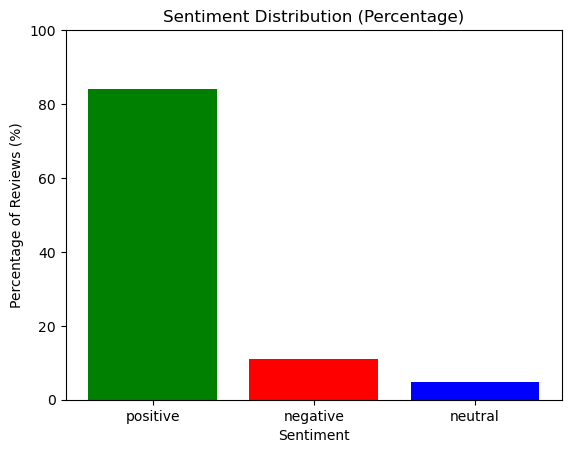

In [11]:
import matplotlib.pyplot as plt

# Calculate sentiment distribution in percentages
sentiment_counts = reviews_df['stars_based_sentiment'].value_counts(normalize=True) * 100  # Normalize to get percentages

# Plot sentiment distribution as percentages
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution (Percentage)")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Reviews (%)")
plt.ylim(0, 100)  # Ensure the y-axis goes up to 100%
plt.show()


### Weekly trends in sentiment based on reviews

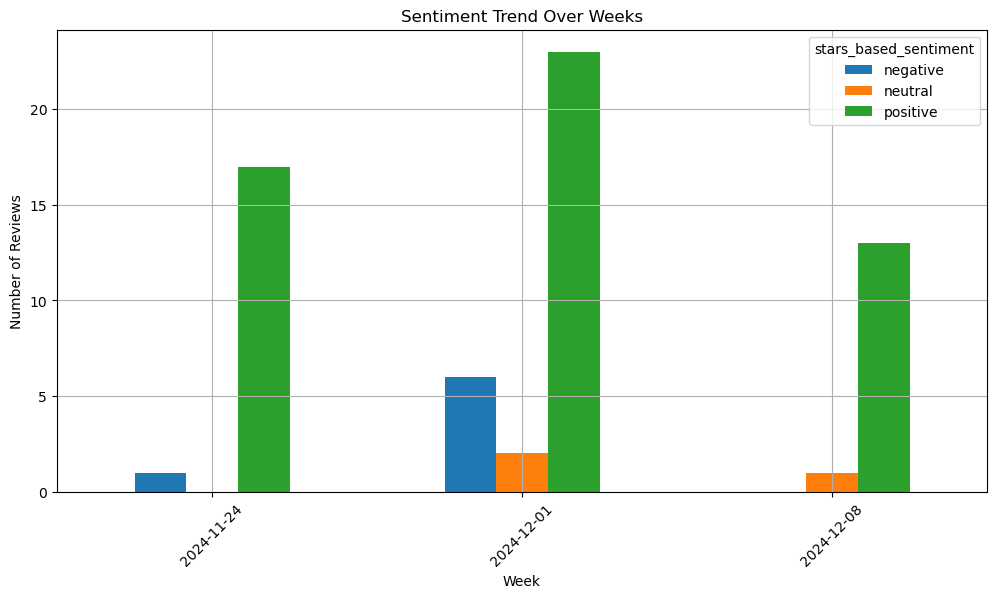

In [12]:
import matplotlib.dates as mdates

# Group sentiment by weeks
sentiment_trend_weekly = reviews_df.groupby([pd.Grouper(key='date', freq='W'), 'stars_based_sentiment']).size().unstack(fill_value=0)

# Plot sentiment trend over weeks
ax = sentiment_trend_weekly.plot(kind='bar', figsize=(12, 6), title="Sentiment Trend Over Weeks")
plt.xlabel("Week")
plt.ylabel("Number of Reviews")
plt.grid(True)

# Format x-axis to show only the date part
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in sentiment_trend_weekly.index], rotation=45)

plt.show()


### Visualize the distribution of sentiment categories across different user groups

In [13]:
user_category_counts = reviews_df['user_category'].value_counts().reset_index()

user_category_counts.columns = ['user_category', 'count']
user_category_counts

,user_category,count
0,Новичок,46
1,Любопытный,9
2,Стажер,5
3,Продвинутый,3


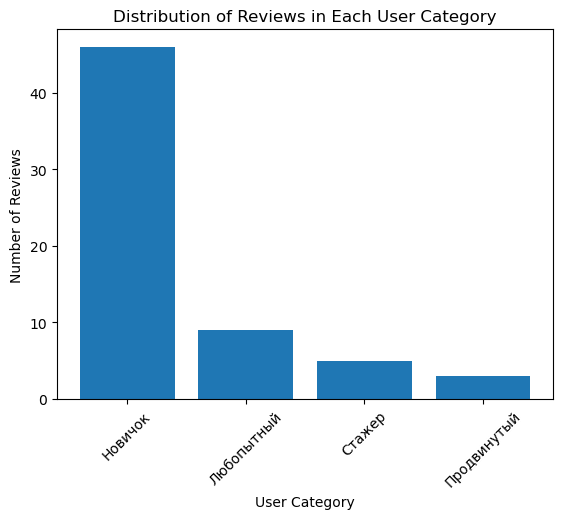

In [14]:
# Plot a bar chart
plt.bar(user_category_counts['user_category'], user_category_counts['count'])
plt.title("Distribution of Reviews in Each User Category")
plt.xlabel("User Category")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


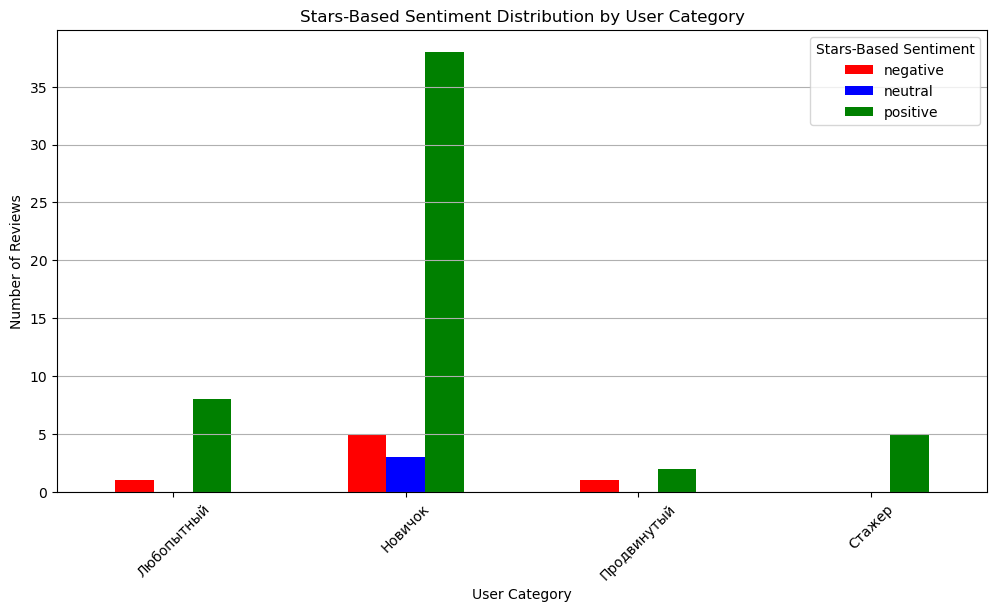

In [15]:
sorted_reviews = reviews_df.sort_values(by='user_level', ascending=True)

sentiment_by_user_category = sorted_reviews.groupby(['user_category', 'stars_based_sentiment']).size().unstack(fill_value=0)

# Plot a stacked bar chart
sentiment_by_user_category.plot(kind='bar', stacked=False, figsize=(12, 6), color=['red', 'blue', 'green'])

# Customize the plot
plt.title("Stars-Based Sentiment Distribution by User Category")
plt.xlabel("User Category")
plt.ylabel("Number of Reviews")
plt.legend(title="Stars-Based Sentiment")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Optional: Add gridlines
plt.show()


In [16]:
# Group by stars and calculate the sum of thumbs_up and thumbs_down
thumbs_table = reviews_df.groupby('stars')[['thumbs_up', 'thumbs_down']].sum()

# Reset the index to make it a clean table
thumbs_table = thumbs_table.reset_index()

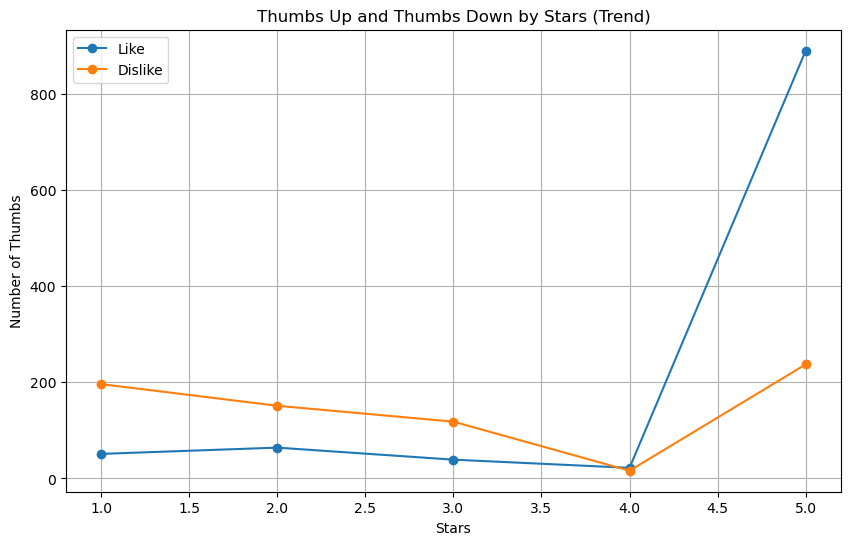

In [17]:
# Plot thumbs_up and thumbs_down as a line chart
thumbs_table.plot(x='stars', y=['thumbs_up', 'thumbs_down'], kind='line', marker='o', figsize=(10, 6))

# Customize the plot
plt.title("Thumbs Up and Thumbs Down by Stars (Trend)")
plt.xlabel("Stars")
plt.ylabel("Number of Thumbs")
plt.legend(["Like", "Dislike"])
plt.grid(True)
plt.show()


The chart reveals a clear pattern: reviews with low star ratings (1–2 stars) tend to attract a high number of thumbs down, suggesting that users actively counter negative feedback about the show. Conversely, highly positive reviews with 5 stars receive overwhelming thumbs up, indicating strong agreement and support. At 4 stars, reactions are more balanced, reflecting general acceptance with less polarization.

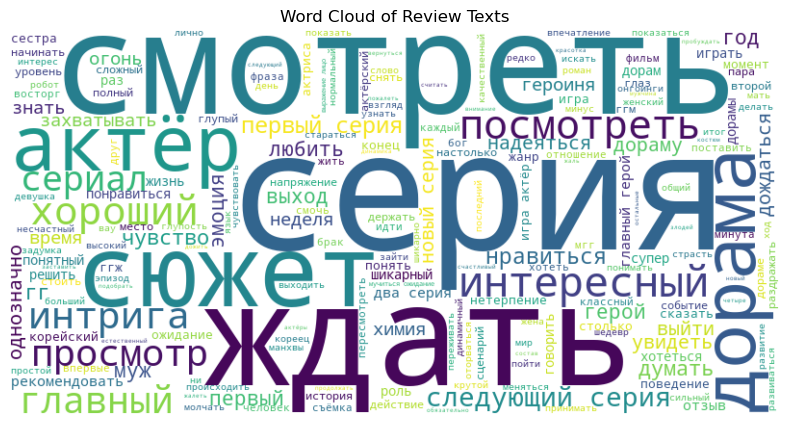

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all review texts into a single string
all_text = " ".join(reviews_df['cleaned_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title("Word Cloud of Review Texts")
plt.show()


In [19]:
from collections import Counter
import pandas as pd

# Combine all cleaned texts into one string
all_text = " ".join(reviews_df['cleaned_text'])

# Split the text into words
words = all_text.split()

# Count word frequencies
word_counts = Counter(words)

# Convert to a DataFrame for better visualization
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the top 10 most frequent words
print(word_freq_df.head(10))


           Word  Frequency
6         серия         86
31        актёр         33
146       ждать         30
41     смотреть         30
81        сюжет         28
62       дорама         25
35       первый         23
89      главный         22
93   интересный         20
4    посмотреть         18


In [20]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Tokenize the cleaned text
tokenized_reviews = [text.split() for text in reviews_df['cleaned_text']]

# Create a dictionary and a corpus
dictionary = Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

# Print the top 5 topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")

# Visualize the topics using pyLDAvis
#vis = gensimvis.prepare(lda_model, corpus, dictionary)
#pyLDAvis.display(vis)


Topic 1: 0.023*"серия" + 0.010*"гг" + 0.010*"история" + 0.010*"нравиться" + 0.009*"интересный"
Topic 2: 0.016*"серия" + 0.015*"актёр" + 0.013*"смотреть" + 0.009*"супер" + 0.009*"главный"
Topic 3: 0.019*"серия" + 0.015*"ждать" + 0.015*"смотреть" + 0.011*"актёр" + 0.009*"неделя"
Topic 4: 0.037*"серия" + 0.016*"дорама" + 0.013*"ждать" + 0.013*"сюжет" + 0.012*"актёр"
Topic 5: 0.026*"серия" + 0.014*"сюжет" + 0.008*"интрига" + 0.008*"первый" + 0.007*"ждать"


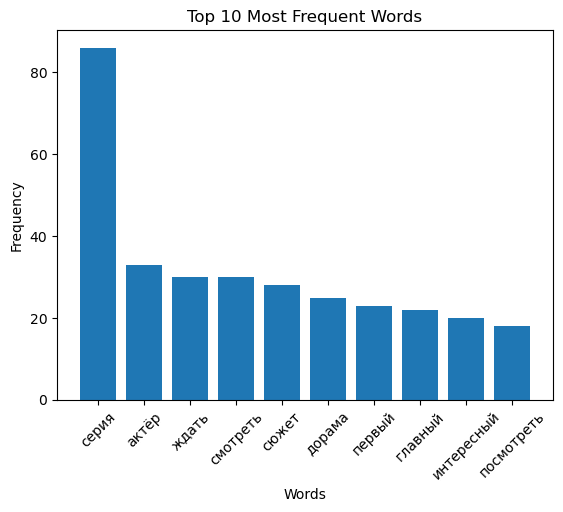

In [21]:
import matplotlib.pyplot as plt

# Plot top 10 most frequent words
top_words = word_freq_df.head(10)
plt.bar(top_words['Word'], top_words['Frequency'])
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [22]:
questions = (
    "О чем идет речь в тексте?",
    "Что говорится о главном герое?",
    "Что сказано о муже?",
    "О чем текст?",
    "Какое слово следует после слова серия",
    "О чем дорама?",
    "Понравился ли сериал?",
    "Что сказано?",
    "Какие положительные слова использованы?",
    "Какие негативные слова встречаются?"


)


In [23]:
from deeppavlov import configs, build_model
model = build_model('squad_ru_bert', download=False, install=False)


/opt/homebrew/anaconda3/envs/reviews_analysis/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrainin

In [24]:
import nltk
#nltk.download('punkt')

In [25]:
#nltk.download('punkt_tab')

In [26]:
# Open a file in write mode
with open("questions_answers.txt", "w", encoding="utf-8") as f:
    # Iterate through the rows of the DataFrame
    for index, row in reviews_df.iterrows():
        text = row['cleaned_text']
        for q in questions:
            answer = model([text], [q])
            confidence = answer[2][0]  # Access the first element if it's a list
            if abs(confidence - 1) > 1e-6:  # Ensure confidence is a float or int
                f.write(f"{q}  {answer[0]}\n")  # Write to file
        f.write('-' * 20 + '\n')  # Add a separator for each row


In [27]:
import textwrap


for review in raw_reviews:
   # Wrap the text to 100 characters per line
    wrapped_text = textwrap.fill(review.text, width=100)
    print(wrapped_text)
    print('-' * 20)

Сериал просто класс, держит в интриге, что же будет дальше. Хотела посмотреть когда выйдут все
серии, но не смогла сдержаться, попадались короткие эпизоды. И это пробуждало интерес, а теперь
мучаюсь в ожидание серий.Когда ж они выйдут?
--------------------
Кто бы,что ни говорил,лично для меня,именно Чхэ Су Бин является олицетворением корейской красоты и в
принципе корейской девушки. Остальные слишком кукольные и не естественные,что актеры что другие без
разницы,она более настоящая и естественная. Мое мнение ещё с 2018 года,когда я в первый раз
посмотрел "Я не робот" и до сих пор так считаю. P.S. Всем добра.
--------------------
Начинаю смотреть: "О, боже, как он элегантен, красив, как ему идёт этот костюм", все европейцы
восхищаются корейцем это такое странное чувство, продолжаю вдруг фраза из красотки: "Не волнуйся,
они смотрят на меня, а не на тебя", после этого хотела выключить и забросить, но решила не сдаваться
и не пожалела. Начинайте смотреть, когда будут почти все серии, чтобы 